In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("zero-to-mastery-ml-master/data/TrainAndValid.csv")

D:\Programming\MACHINE_LEARNING\ML_ENV\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.saledate = df.saledate.apply(lambda x : pd.Timestamp(x))

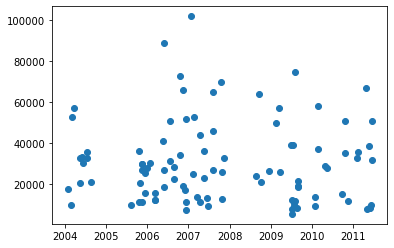

In [4]:
test_df=df[["saledate","SalePrice"]][:100]
plt.scatter(test_df["saledate"],test_df["SalePrice"])

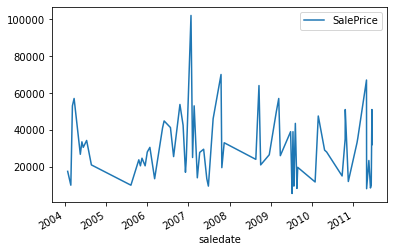

In [5]:
test_df.groupby("saledate").mean().plot();

In [6]:
df.saledate[1].month

3

In [7]:
df["UsageBand"].astype("category")

0            Low
1            Low
2           High
3           High
4         Medium
           ...  
412693       NaN
412694       NaN
412695       NaN
412696       NaN
412697       NaN
Name: UsageBand, Length: 412698, dtype: category
Categories (3, object): ['High', 'Low', 'Medium']

In [8]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical

In [9]:
## Turning all string(categories) values to real categorical types in pandas

def turn_from_string(df):
    for column, data in df.items():
        if is_string_dtype(data):
            df[column]= data.astype("category")

In [10]:
turn_from_string(df)

## Now let's fill all the missing values

In [11]:
## First the numerical ones

def zero_from_numeric(df):
    for column, data in df.items():
        if is_numeric_dtype(data):
            df[column].fillna(data.median())
            
zero_from_numeric(df)

In [12]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [13]:
## Then the string values

def zero_from_string(df):
    for column,data in df.items():
        if is_categorical(data):
            df[column] = df[column].cat.codes + 1
            
            
zero_from_string(df)

<ipython-input-13-12c4f1409eb0>:5: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(data):


In [14]:
df["auctioneerID"].fillna(df["auctioneerID"].mean,inplace=True)
df["MachineHoursCurrentMeter"].fillna(df["MachineHoursCurrentMeter"].mean,inplace=True)
turn_from_string(df)
zero_from_string(df);

<ipython-input-13-12c4f1409eb0>:5: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(data):


In [15]:
## Splitting into Training and Validation Sets

In [16]:
df["SaleYear"]=[n.year for n in df["saledate"]]

In [17]:
df_test=df[df.SaleYear != 2012]
df_valid= df[df.SaleYear == 2012]

df_test.shape,df_valid.shape

((401125, 54), (11573, 54))

In [18]:
X_train,y_train=df_test.drop("SalePrice",axis=1),df_test["SalePrice"]
X_valid,y_valid=df_valid.drop("SalePrice",axis=1),df_valid["SalePrice"]

X_train.shape,X_valid.shape

((401125, 53), (11573, 53))

In [19]:
## Creating a function to calculate the root of mean_squared_error, as well as calculating other basic metrics

from sklearn.metrics import mean_squared_log_error,mean_absolute_error,r2_score

def rmse(true,pred):
    
    res=mean_squared_log_error(true,pred)
    ## Getting the root of the square
    res=np.sqrt(res)
    
    return res

def scores(model): 
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    scores = {"Mean abs. error -train": mean_absolute_error(y_train,train_pred),
             "Mean abs. error - valid": mean_absolute_error(y_valid,valid_pred),
             "RMSLE - train": rmse(y_train,train_pred),
             "RMSLE - valid": rmse(y_valid,valid_pred),
             "R2 - train": r2_score(y_train,train_pred),
             "R2 - valid": r2_score(y_valid,valid_pred)}
    return scores

In [20]:
from sklearn.ensemble import RandomForestRegressor

## Reducing sample size so that fitting takes less time

model = RandomForestRegressor(random_state=42,n_jobs=-1,max_samples=10000)

In [21]:
model.fit(X_train,y_train)

TypeError: The DTypes <class 'numpy.dtype[datetime64]'> and <class 'numpy.dtype[int64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

In [22]:
## REmoving datetime column, because it creates conflict when fitting the data to the model. We created a SaleYear column from it, so it's OK to drop it
X_train.drop("saledate",axis=1,inplace=True)
X_valid.drop("saledate", axis=1, inplace=True)

In [23]:
%%time
model.fit(X_train,y_train)

Wall time: 3.98 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [24]:
scores(model)

{'Mean abs. error -train': 5490.113293935806,
 'Mean abs. error - valid': 6999.790330942711,
 'RMSLE - train': 0.2543947772176714,
 'RMSLE - valid': 0.28442293841206356,
 'R2 - train': 0.8640110625639308,
 'R2 - valid': 0.8363837817397097}

In [28]:
## Let's find the best hyperparameters

from sklearn.model_selection import RandomizedSearchCV

params={"n_estimators": [50,100,250,500],
        "criterion": ["mse","mae"],
        "max_depth":[10,20,5,None],
        "min_samples_split":[2,4,7],
        "max_features":["auto","log2"]       
}


best_model=RandomizedSearchCV(model,params,cv=5,n_iter=2,verbose= True,random_state=42)

In [29]:
best_model.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_samples=10000, n_jobs=-1,
                                                   random_state=42),
                   n_iter=2,
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'max_depth': [10, 20, 5, None],
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_split': [2, 4, 7],
                                        'n_estimators': [50, 100, 250, 500]},
                   random_state=42, verbose=True)

In [31]:
best_params=best_model.best_params_
best_model_params=RandomForestRegressor(**best_params)

In [33]:
best_model_params.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, max_features='log2', min_samples_split=7)

In [35]:
scores(best_model_params)

{'Mean abs. error -train': 4872.4259267838615,
 'Mean abs. error - valid': 6601.181032621778,
 'RMSLE - train': 0.22522701484651758,
 'RMSLE - valid': 0.26955294820646086,
 'R2 - train': 0.898533404256759,
 'R2 - valid': 0.856957482570315}

In [36]:
predictions=best_model_params.predict(X_valid)

In [42]:
df_valid["Prediction"]=predictions
df_valid["Pred_difference"] = df_valid.Prediction - df_valid.SalePrice

In [43]:
df_valid[['SalePrice',"Prediction","Pred_difference"]]

,SalePrice,Prediction,Pred_difference
401125,31000.0,41181.070183,10181.070183
401126,54000.0,66045.978332,12045.978332
401127,26500.0,36051.555247,9551.555247
401128,10000.0,19284.588157,9284.588157
401129,35000.0,43469.396335,8469.396335
...,...,...,...
412693,10000.0,12333.639472,2333.639472
412694,10500.0,14159.098132,3659.098132
412695,12500.0,11130.078953,-1369.921047
412696,10000.0,12676.908060,2676.908060


<AxesSubplot:>

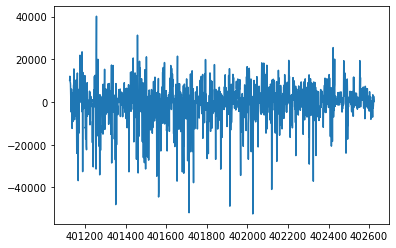

In [47]:
df_valid["Pred_difference"][:1500].plot()

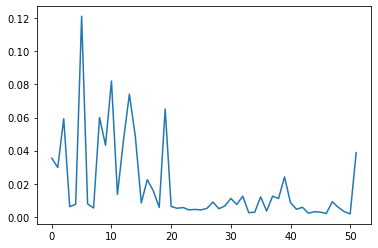

In [50]:
plt.plot(best_model_params.feature_importances_)